In [1]:
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


Import Data

In [2]:
df = pd.read_csv('/Users/duthie/Desktop/MyProjects/DataScience Projects/sentimentanalysis/twitter_sentiment.csv', header=None, index_col=[0])
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
df.tail()

,sentiment,text
75677,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,Positive,Today sucked so it’s time to drink wine n play...
75680,Positive,Bought a fraction of Microsoft today. Small wins.
75681,Neutral,Johnson & Johnson to stop selling talc baby po...


Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
print("\nDataset Description:")
print(df.describe())


Dataset Description:
       sentiment                                               text
count      75682                                              74996
unique         4                                              69972
top     Negative  It is not the first time that the EU Commissio...
freq       22808                                                172


In [6]:
df['sentiment'].value_counts()

sentiment
Negative      22808
Positive      21109
Neutral       18603
Irrelevant    13162
Name: count, dtype: int64

In [7]:
df.columns  

Index(['sentiment', 'text'], dtype='object')

Data Cleaning

In [8]:
df.isnull().sum()

sentiment      0
text         686
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [11]:
df['text'] = df['text'].apply(lambda x: x.lower())


In [12]:
# Remove any special characters or numbers
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

Data Visualization

<Axes: ylabel='count'>

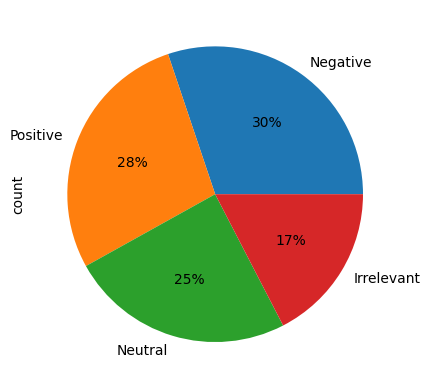

In [13]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [14]:
stopwords = set(STOPWORDS)

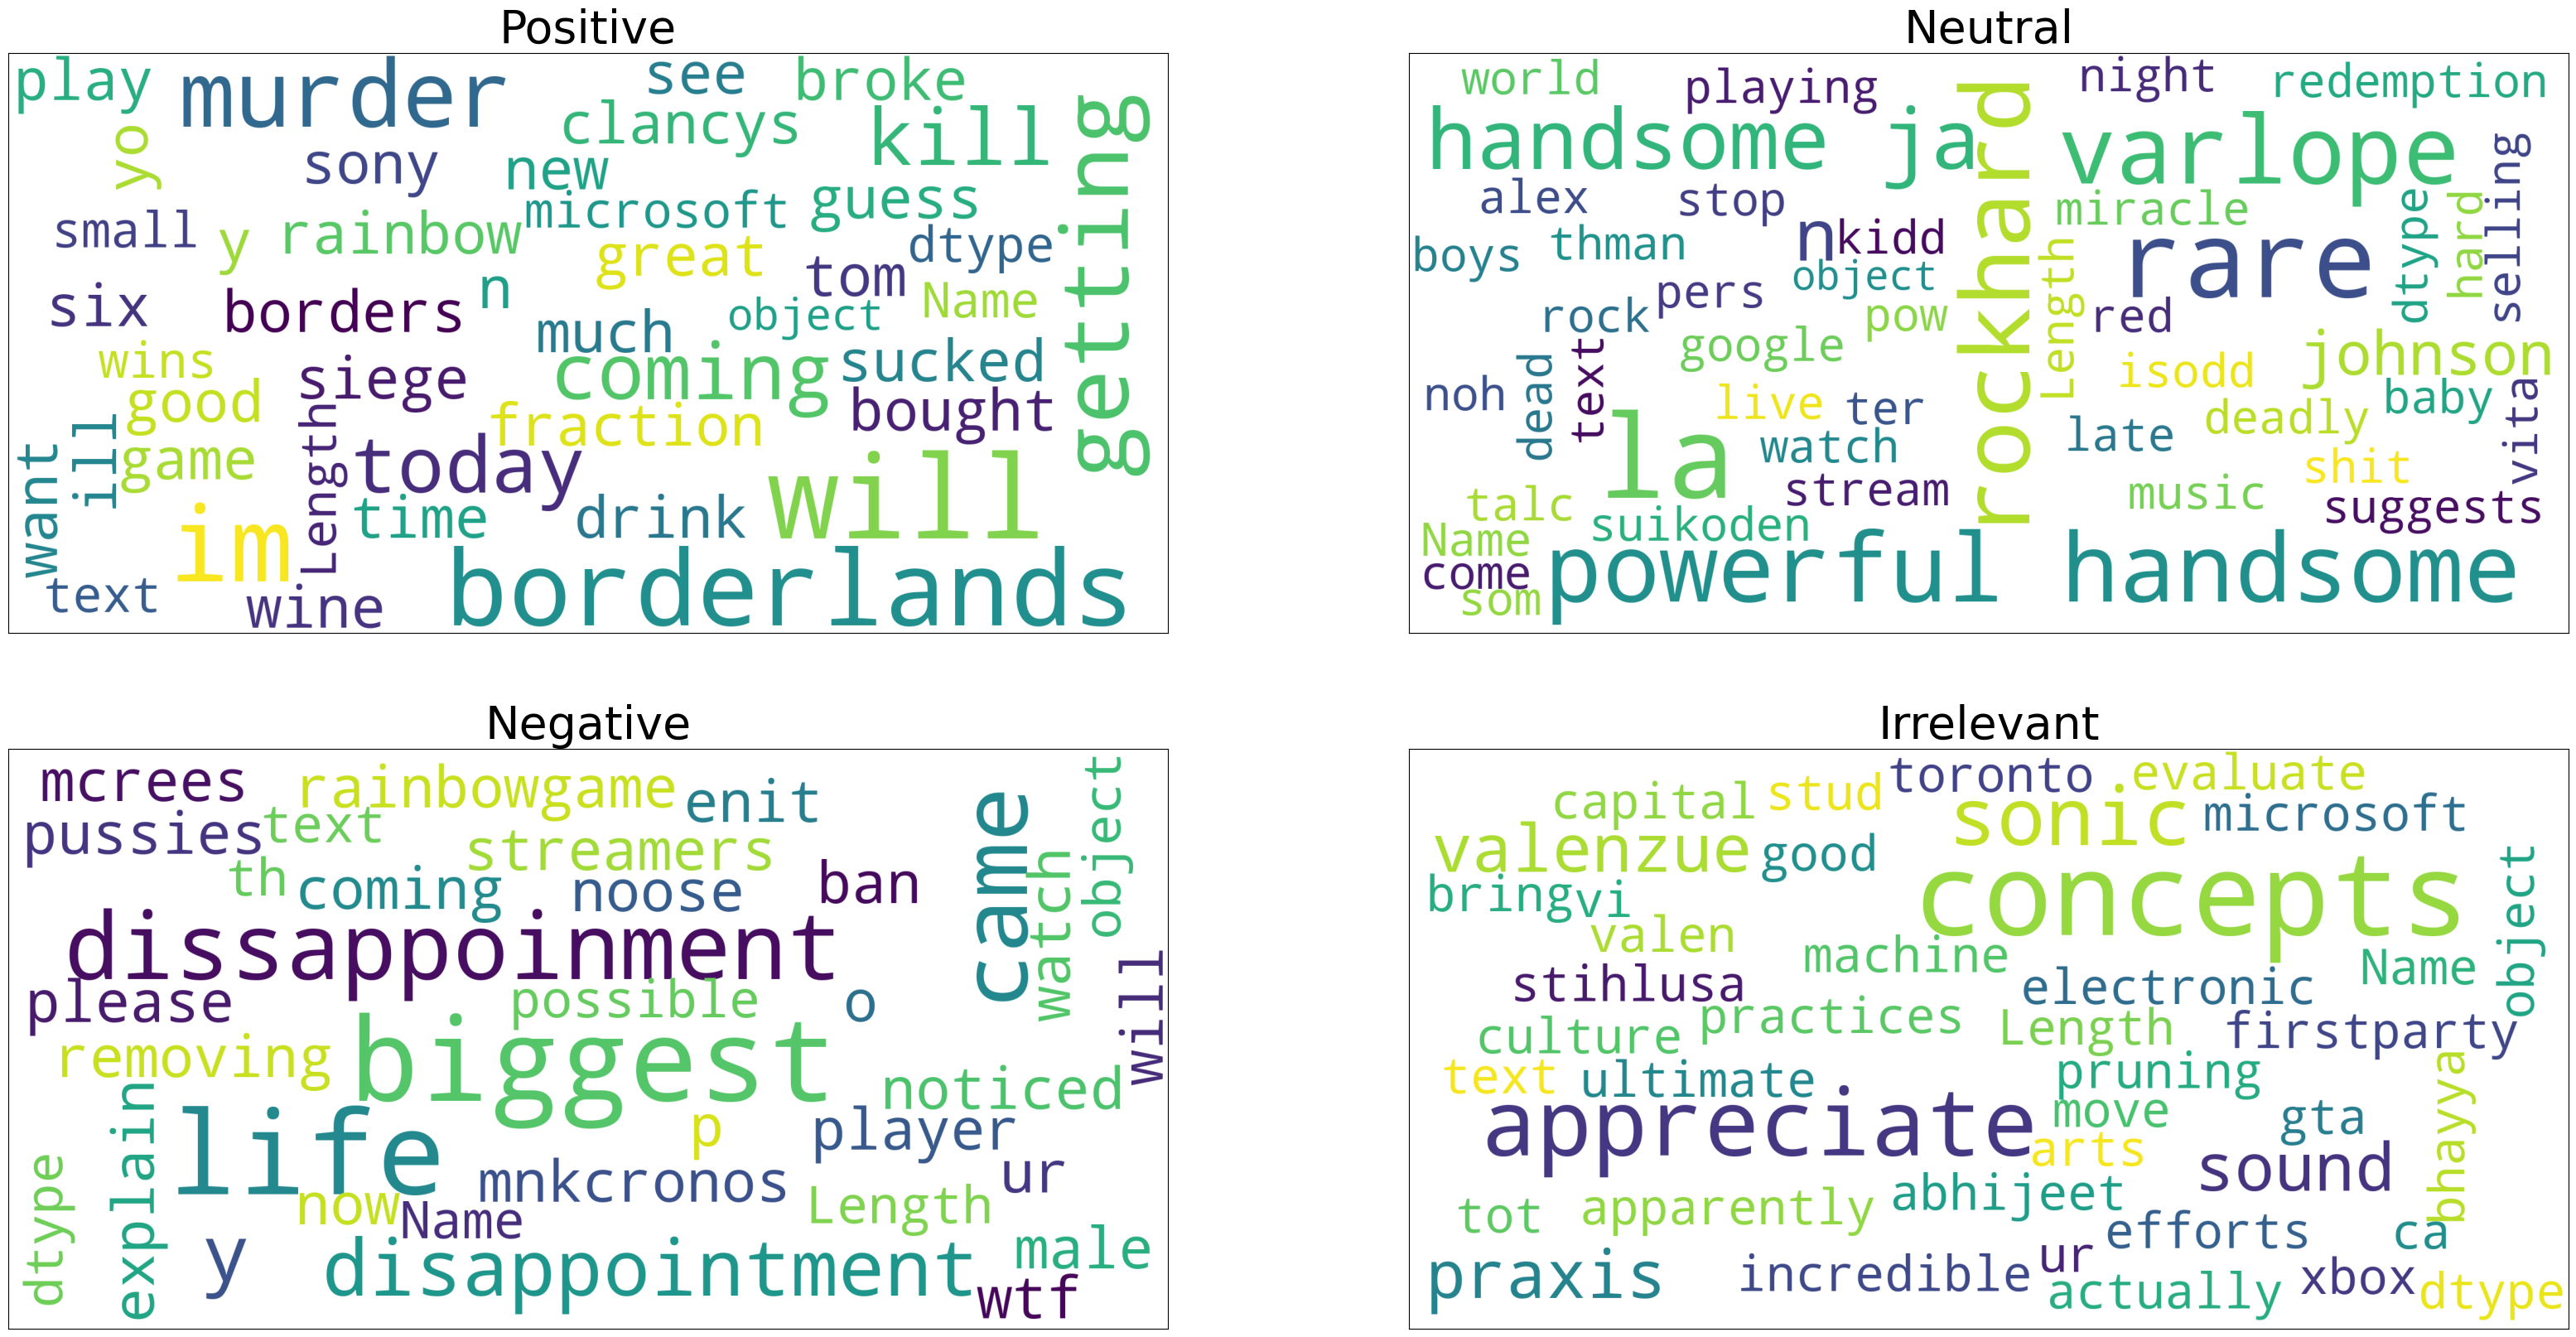

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)
    
plt.show()
plt.tight_layout()

In [16]:
import preprocess_kgptalkie as ps
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x))

In [17]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/duthie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['text'] = df['text'].apply(remove_stopwords)

In [19]:
# Prepare the data for the model
X = df['text']
y = df['sentiment']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

In [21]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [22]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [23]:
y_pred = model.predict(X_test)


In [24]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 87.83%
Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.94      0.79      0.86      2666
    Negative       0.91      0.91      0.91      4464
     Neutral       0.89      0.86      0.88      3706
    Positive       0.82      0.92      0.86      4164

    accuracy                           0.88     15000
   macro avg       0.89      0.87      0.88     15000
weighted avg       0.88      0.88      0.88     15000



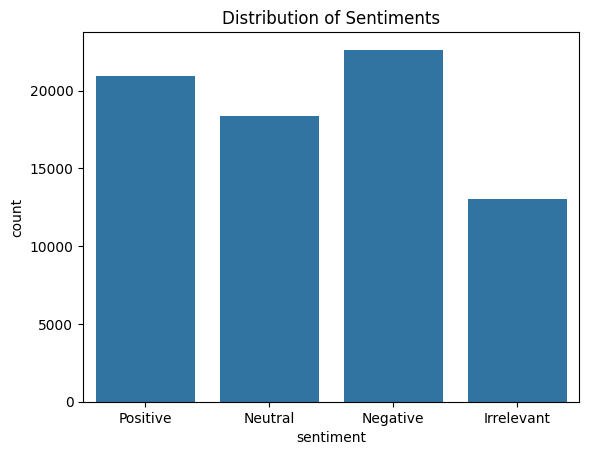

In [28]:
# Visualize some results
import seaborn as sns
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

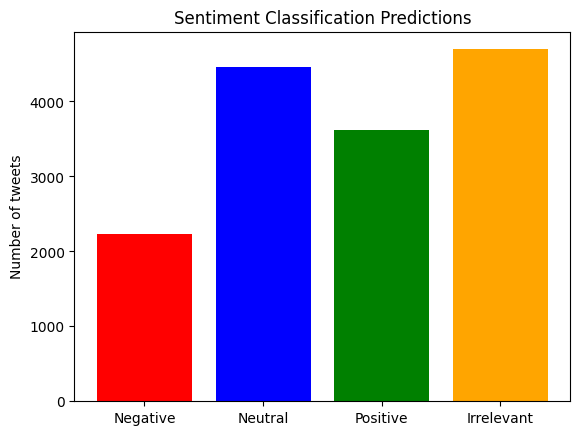

In [36]:
# Plotting the model performance
labels = ['Negative', 'Neutral', 'Positive','Irrelevant']
y_pred_counts = np.unique(y_pred, return_counts=True)[1]

plt.bar(labels, y_pred_counts, color=['red', 'blue', 'green','orange'])
plt.title("Sentiment Classification Predictions")
plt.ylabel("Number of tweets")
plt.show()

In [41]:
import pickle

# Save both the model and the TfidfVectorizer
filename = 'twitter_sentiment_model.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model, file)

with open(vectorizer_filename, 'wb') as file:
    pickle.dump(tfidf, file)

print("Model and vectorizer saved!")

Model and vectorizer saved!
